The Facies classification project for SEG A test notes is appended at bottom
The project has three parts :
1. Raw Data analysis (Small data, quick statistics)

2. Feature Engineering
    a. Missing "PE" data : Regressional fillin is better than median and mean (https://github.com/seg/2016-ml-contest/blob/master/LA_Team/Facies_classification_LA_TEAM_05.ipynb)
    b. How many features to include : 
      Current tests from other groups use only pre-defined features. 
      I found Formation has predicting power too, including Formation info give extra uplift to my model See test 8,9
    c. Feature augmentation : https://github.com/seg/2016-ml-contest/blob/master/ispl/facies_classification_try02.ipynb
      Great works, included the depth information in a nature way
    d. Robust model scaling 

3. Model Selection
   XGBOOST is superior to SVC (My benchmark)
   A brutal gridsearch was done on XGBOOST on top of the best feature engineering  

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [6]:
## Read in data
train_raw = pd.read_csv('01_raw_data/facies_vectors.csv')
train = train_raw.copy()
cols = train.columns.values
well = train["Well Name"].values
depth = train["Depth"].values

In [7]:
## 01 Raw data analysis
print("No. of Wells is " + str(len(train["Well Name"].unique())))
print("No. of Formation is " + str(len(train["Formation"].unique())))
well_PE_Miss = train.loc[train["PE"].isnull(),"Well Name"].unique()
#print("Wells with Missing PE " + well_PE_Miss)
#print(train.loc[train["Well Name"] == well_PE_Miss[0],["PE","Depth"]].count())
#print(train.loc[train["Well Name"] == well_PE_Miss[1],["PE","Depth"]].count())
#print(train.loc[train["Well Name"] == well_PE_Miss[2],["PE","Depth"]].count())
(train.groupby("Well Name"))["PE"].mean()
(train.groupby("Well Name"))["PE"].median()

No. of Wells is 10
No. of Formation is 14


Well Name
ALEXANDER D           NaN
CHURCHMAN BIBLE    3.7400
CROSS H CATTLE     3.2010
KIMZEY A              NaN
LUKE G U           3.6000
NEWBY              3.7000
NOLAN              3.5980
Recruit F9         5.3715
SHANKLE            3.1000
SHRIMPLIN          4.0000
Name: PE, dtype: float64

In [8]:
### 02 Feature definition and QC functions
features = ['GR', 'ILD_log10', 'DeltaPHI', 
    'PHIND','PE','NM_M', 'RELPOS']
feature_vectors = train[features]
facies_labels = train['Facies']
## 1=sandstone  2=c_siltstone   3=f_siltstone 
## 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
## 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
train.loc[:,'FaciesLabels'] = train.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [9]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(10, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    ax[5].plot(logs.NM_M, logs.Depth, '-', color='black')
    im=ax[6].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('NoMarine/Marine')
    ax[6].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)


In [10]:
### 03 Feature Engineering tests (SVC and XGB were used to test this)
## a. Fill in missing PE values : Median, mean, NN regressor
## b. Feature augmentaions
## c. Additional dummy features : Formation 
## d. Featuere scaling
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [14]:
X_feat = {}
## Feature Engeering 1 : With dummy variable from Formation
## Create dummy variables for Well Name, Formation, which may have geologic or geospatial information
train_dummy = pd.get_dummies(train[["Formation"]])
train_dummy.describe()
cols_dummy = train_dummy.columns.values
train[cols_dummy] = train_dummy[cols_dummy]
train_inp = train.drop(["Formation","Well Name",'FaciesLabels',"Depth"],axis =1)
X_fe1 = train_inp.drop(["Facies"],axis = 1).values
X_feat.update({"X_fe1" : X_fe1})
#
## Feature Engeering 2 : With dummy variable from Formation and feature augmentation
train["PE"] = train_raw["PE"].fillna(train_raw["PE"].median())
train_inp = train.drop(["Formation","Well Name",'FaciesLabels',"Depth"],axis =1)
X_fe1 = train_inp.drop(["Facies"],axis = 1).values
X_fe1_aug, padded_rows = augment_features(X_fe1, well, depth,N_neig = 1)
X_feat.update({"X_fe2" : X_fe1_aug})


## Feature Engeering 3 : With dummy variable from Formation and feature augmentation
## Fill Nan PE with mean
train["PE"] = train_raw["PE"].fillna(train_raw["PE"].mean())
train_inp = train.drop(["Formation","Well Name",'FaciesLabels',"Depth"],axis =1)
X_fe1 = train_inp.drop(["Facies"],axis = 1).values
X_fe1_aug, padded_rows = augment_features(X_fe1, well, depth,N_neig = 1)
X_feat.update({"X_fe3" : X_fe1_aug})


### Feature Engeering 4 : With dummy variable from Formation and feature augmentation
### Fill Nan PE with MPRRegressor
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor()
DataImpAll = train_raw.drop(['Formation', 'Well Name', 'Depth'], axis=1).copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
train.loc[np.array(DataImpAll.PE.isnull()),"PE"] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))
train_inp = train.drop(["Formation","Well Name",'FaciesLabels',"Depth"],axis =1)
X_fe1 = train_inp.drop(["Facies"],axis = 1).values
X_fe1_aug, padded_rows = augment_features(X_fe1, well, depth,N_neig = 1)
X_feat.update({"X_fe4" : X_fe1_aug})


### Feature Engeering 5 : Drop dummy formation compared to Feature 4
X_fe1 = (train_inp.drop(["Facies"],axis = 1)).drop(cols_dummy,axis=1).values
X_fe1_aug, padded_rows = augment_features(X_fe1, well, depth,N_neig = 1)
X_feat.update({"X_fe5" : X_fe1_aug})

## Select which feature engineering for next model test
# Feature enginering Selection 
X_tr = X_feat["X_fe4"]
y = train["Facies"].values
## Feature Scaling
from sklearn import preprocessing
scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
X = scaler.transform(X_tr)


In [15]:
## Reading Test dataset and process the same way as trainning
test = pd.read_csv('01_raw_data/validation_data_nofacies.csv')
## Test data Check
print(test.count())  # Make sure no missing data in test
print("No. of Formation in test is " + str(len(test["Formation"].unique())))
## Dummy formation
test_dummy = pd.get_dummies(test[["Formation"]])
test_cols_dummy = test_dummy.columns.values
test[test_cols_dummy] = test_dummy[cols_dummy]
## Feature augmentaion
Well_test = test["Well Name"].values
Depth_test = test["Depth"].values
test_inp = test.drop(["Formation","Well Name","Depth"],axis =1)
test_fe = test_inp.values
test_aug,t_pad_row = augment_features(test_fe,Well_test,Depth_test)
## Scaling
X_test = scaler.transform(test_aug)

Formation    830
Well Name    830
Depth        830
GR           830
ILD_log10    830
DeltaPHI     830
PHIND        830
PE           830
NM_M         830
RELPOS       830
dtype: int64
No. of Formation in test is 14


In [16]:
# Split Group
from sklearn.model_selection import LeavePGroupsOut
lpgo = LeavePGroupsOut(n_groups=2)
#split_no = lpgo.get_n_splits(X,y,wellgroups)
train_index=[]
val_index = []
for tr_i,val_i in lpgo.split(X, y, groups=train['Well Name'].values):
    hist_tr = np.histogram(y[tr_i], bins=np.arange(len(facies_labels)+1)+0.5)
    hist_val = np.histogram(y[val_i], bins=np.arange(len(facies_labels)+1)+0.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):    
        train_index.append(tr_i)
        val_index.append(val_i)
split_no = len(train_index)

In [17]:
from sklearn.multiclass import OneVsOneClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from scipy.signal import medfilt
seed = 123

param = {'alpha': 0.2,
 'colsamplebytree': 0.8,
 'gamma': 0.3,
 'learningrate': 0.05,
 'maxdepth': 8,
 'minchildweight': 1,
 'n_estimators': 200,
 'subsample': 0.7}


/home/computer/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
clf = XGBClassifier(
            learning_rate = param['learningrate'],
            n_estimators=param['n_estimators'],
            max_depth=param['maxdepth'],
            min_child_weight=param['minchildweight'],
            gamma = param['gamma'],
            subsample=param['subsample'],
            colsample_bytree=param['colsamplebytree'],
            reg_alpha = param['alpha'],
            nthread =4,
            seed = seed,
        ) 
svc_best = SVC(C = 10, gamma = 0.01, kernel = 'rbf')

In [20]:
## Always compare XGBOOST with SVC
f1 = np.zeros((split_no,1))
f1_svc = np.zeros((split_no,1))
for i in range(split_no):
    X_train = X[train_index[i]]
    Y_train = y[train_index[i]]
    X_val = X[val_index[i]]
    Y_val = y[val_index[i]]
    print(i)
    ### XGBOOST
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_val)
#    y_pred = medfilt(y_pred,kernel_size=5)
    f1[i] = f1_score(Y_val, y_pred, average='micro')  
    
    
    svc_best.fit(X_train,Y_train)
    Y_pred = svc_best.predict(X_val)
#    Y_pred = medfilt(Y_pred,kernel_size=5)
    f1_svc[i] = f1_score(Y_val, Y_pred, average='micro')  
    
print("XGBOOST score " + str(np.mean(f1)))
print("SVC score" + str(np.mean(f1_svc)))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
XGBOOST score 0.5566255547
SVC score0.507083646628


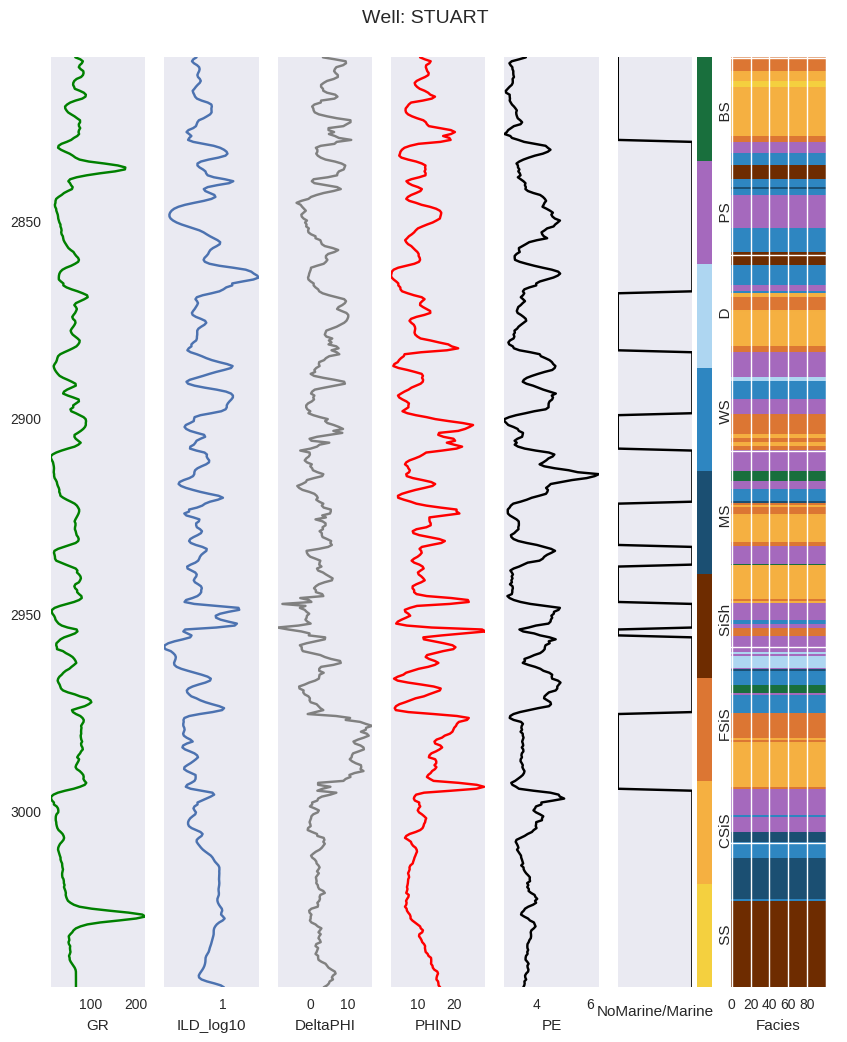

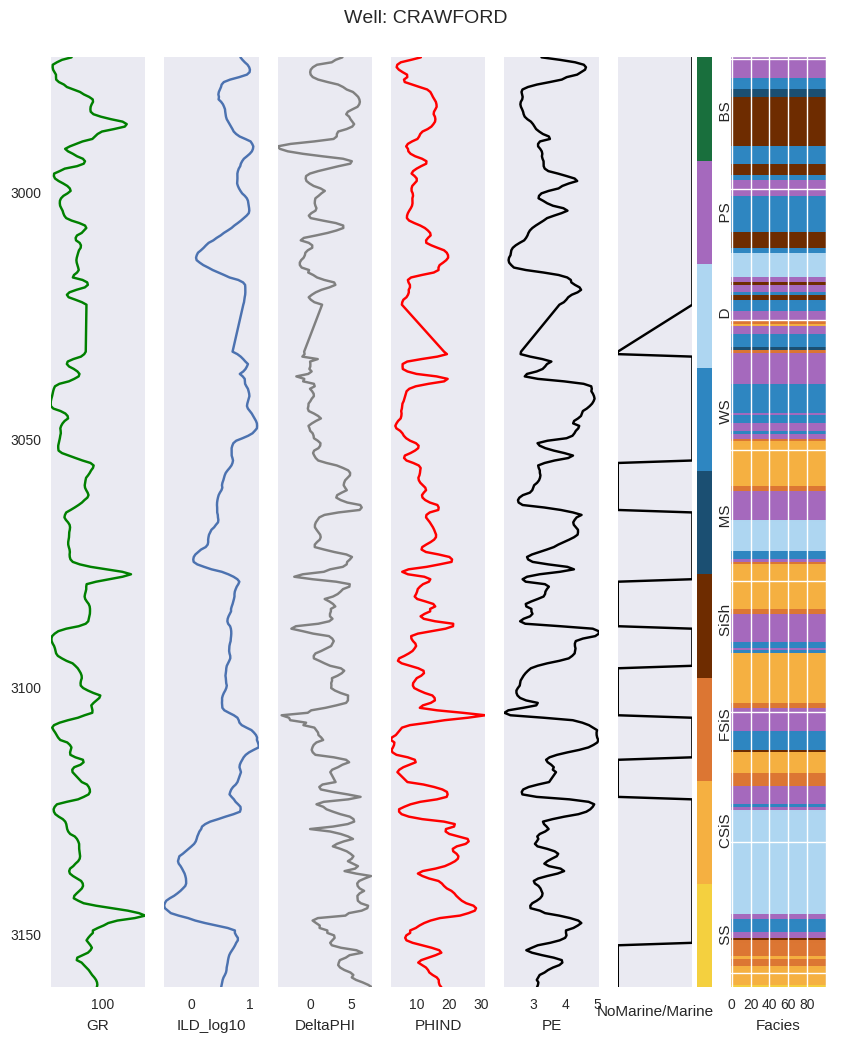

In [24]:

## Predict for testing data
# Plot predicted labels
test_facies = clf.predict(X_test)
test["Facies"] = test_facies
test.to_csv("HoustonJ_sub2.csv")

make_facies_log_plot(
    test[test['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    test[test['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)
plt.show()

HoustonJ's test notes

Facies Classification :
 
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

Facies Description Label Adjacen facies
1 Nonmarine sandstone  SS 2
2 Nonmarine coarse siltstone CSiS 1,3
3 Nonmarine fine siltstone FSiS 2
4 Marine siltstone and shale SiSh 5
5 Mudstone MS 4,6
6 Wackestone WS 5,7,8
7 Dolomite D 6,8
8 Packstone-grainstone PS 6,7,9
9 Phylloid-algal bafflestone BS 7,8

Features : 'Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10','DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'

Pre-processing 1: 
1. Well 'ALEXANDER D', 'KIMZEY A' has missing PE, filled in with median values 
2. Map "Formation", "Well Name" into dummy features ; Effective features increase from 8 to 21
3. Robust normalization, dropping depth


Pre-processing 2: 
1. Well 'ALEXANDER D', 'KIMZEY A' has missing PE, filled in with median values 
2. Map "Formation", "Well Name" into dummy features ; Effective features increase from 8 to 21
3. Feature augmentation
4. Robust normalization, dropping depth

Pre-processing 3: 
1. Well 'ALEXANDER D', 'KIMZEY A' has missing PE, filled in with mean values 
2. Map "Formation", "Well Name" into dummy features ; Effective features increase from 8 to 21
3. Feature augmentation
4. Robust normalization, dropping depth

Pre-processing 4: 
1. Well 'ALEXANDER D', 'KIMZEY A' has missing PE, filled in NN Regressor
2. Map "Formation", "Well Name" into dummy features ; Effective features increase from 8 to 21
3. Feature augmentation
4. Robust normalization, dropping depth

Pre-processing 5: 
1. Well 'ALEXANDER D', 'KIMZEY A' has missing PE, filled in with mean values 

3. Feature augmentation
4. Robust normalization, dropping depth

Model_selection_pre:
Split group by Well Name : 2 test 8 train

Test 1 : The pre-processing 1
Radomly choose one slipt and run SVC vs XGBOOST
f1 score  : SVC 0.486  <  XGBOOST 0.535
Conclusion_pre : XGBOOST > SVC 

Feature Engineering Selection : 
Test 2 : The pre-processing 1
XGBOOST for all splits : 0.535
Houmath Best : 0.563

Test3 : The feature augmentation 
XGBOOST score 0.552620109649
SVC score0.502307800369

Test 4 : The feature augmentation N_neig = 2
XGBOOST score 0.544176923417
SVC score0.489872101252

Test 5 : The pre-processing 2  
XGBOOST score 0.557558000862
SVC score0.499220019065

Test 6 : The pre-processing 3  
XGBOOST score 0.557884804169
SVC score0.500650895029

Test 7 : The pre-processing 3  y_pre = medfil size 5
XGBOOST score 0.559944170153
SVC score0.509190227257

Test 8 : The pre-processing 4  y_pre = medfil size 5
XGBOOST score 0.566146182295
SVC score0.507362308656

Test 9 : The pre-processing 5 Drop Formation dummy  y_pre = medfil size 5
XGBOOST score 0.555870232144
SVC score0.509423764916

Model Optimization : 
Test 10 : The pre-processing 4  y_pre = medfil size 5
Grid Search for XGBOOST parameters

Learning_rate 0.05, n_estimators : 200 ; Hope not overfitting
XGBOOST score 0.563599674886
SVC score0.510516447302
